In [1]:
import glob
import string
import unicodedata
import re
from collections import Counter
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

from livelossplot import PlotLosses

import pandas as pd

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    print(torch.cuda.get_device_name())
    device = 'cuda'
else:
    print("No GPU available! Running on CPU")

No GPU available! Running on CPU


In [3]:
class WordsTensorDataset(TensorDataset):
    def __init__(self, data_list, sequence_length=4):
        """
        Args:
            data_list (dictionary): A list of all the words in the file
            sequence_length: the number of words in each input sample, and output sample
        """
        self.sequence_length = sequence_length
        self.data_list = data_list
        self.unique_words = self.get_unique_words()

        self.word_to_idx = {word: idx for idx, word in enumerate(self.unique_words)}  # creates a dictionary of mappings of words to indices
        self.idx_to_word = {idx: word for idx, word in enumerate(self.unique_words)}  # creates a dictionary of mappings of indices to words     

        self.words_idxs = [self.word_to_idx[word] for word in data] # returns a list of the dat with the words represented with their indices

    def get_unique_words(self):
        word_counts = Counter(self.data_list)
        return sorted(word_counts, key=word_counts.get, reverse=True)  # returns a list of the unique words sorted in ascending order

    def __len__(self):
        return len(self.words_idxs) - self.sequence_length

    def __getitem__(self, idx):

        sample_input = torch.tensor(self.words_idxs[idx:idx+self.sequence_length])
        sample_output = torch.tensor(self.words_idxs[idx+1:idx+self.sequence_length+1])

        return sample_input, sample_output

In [4]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in string.ascii_letters
    )

print(unicode_to_ascii('București'))

Bucuresti


In [5]:
def readFile_txt(filename): 
    """ 
    Read a txt file and return list with line entries 
    """
    lines = re.split(' |\n',open(filename, encoding="utf8").read().strip())
    return [unicode_to_ascii(line) for line in lines]

data = readFile_txt('data_gen/reddit-cleanjokes.csv')

In [6]:
def readFile_csv(filename, header):
    """ 
    Read a csv file and return list with line entries 
    """
    dataframe = pd.read_csv(filename)
    data = dataframe[header].str.cat(sep=' ')
    data = data.split(' ')
    return data

filename, header = 'data_gen/reddit-cleanjokes.csv', 'Joke'
data = readFile_csv(filename, header)
#print((data))
print(len(data))

23914


In [7]:
word_counts = Counter(data)
uniq_words = sorted(word_counts, key=word_counts.get, reverse=True)
#print(uniq_words)
print(len(word_counts))

6925


In [8]:
word_to_index = {word: index for index, word in enumerate(uniq_words)}
index_to_word = {index: word for index, word in enumerate(uniq_words)}

words_indexes = [word_to_index[word] for word in data]
#print(words_indexes)

In [9]:
sequence_length= 4
index = 0
tensor_in = torch.tensor(words_indexes[index:index+sequence_length])
tensor_out =torch.tensor(words_indexes[index+1:index+sequence_length+1])

print(tensor_in)
print(tensor_out)

tensor([  2,   8,   0, 248])
tensor([  8,   0, 248,  20])


In [10]:
words_dataset = WordsTensorDataset(data, sequence_length=4)
words_dataloader = DataLoader(words_dataset, batch_size=5, shuffle=False)

next(iter(words_dataloader))

[tensor([[   2,    8,    0,  248],
         [   8,    0,  248,   20],
         [   0,  248,   20,    4],
         [ 248,   20,    4,    0],
         [  20,    4,    0, 1905]]),
 tensor([[   8,    0,  248,   20],
         [   0,  248,   20,    4],
         [ 248,   20,    4,    0],
         [  20,    4,    0, 1905],
         [   4,    0, 1905, 1906]])]

In [11]:
class LSTM_GEN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, num_layers, num_unique_words):
        super(LSTM_GEN, self).__init__()

        self.input_size = input_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_unique_words = num_unique_words
        self.batch_size = batch_size
        
        self.embedding = nn.Embedding(self.num_unique_words, self.embedding_dim)
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, self.num_unique_words)


    def init_states_h_c(self, batch_size):
          return (torch.zeros(self.num_layers, batch_size, self.hidden_size, requires_grad=True).to(device),
          torch.zeros(self.num_layers, batch_size, self.hidden_size,  requires_grad=True).to(device))


    def forward(self, x):
        
        batch_size = x.size(0)
        (state_h, state_c) = self.init_states_h_c(batch_size)
        embedded = self.embedding(x)
        output, (state_h, state_c) = self.lstm(embedded, (state_h, state_c))
        logits = self.fc(output)
        return logits, (state_h, state_c)


def count_trainable_parameters(model):
    return sum([p.numel() for p in model.parameters() if p.requires_grad])

In [12]:
def train_lstm_gen(model, optimizer, criterion, dataloader):
    model.train()
    train_loss, train_accuracy = 0, 0
    
    for i, (x, y) in enumerate(dataloader):

        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred, (state_h,state_c) = model(x)
        
        loss = criterion(y_pred.permute(0,2,1), y)               #change shape as crossentropy takes input as batch_size, number of classes, d1, d2, ...
        train_loss += loss

        loss.backward()
        optimizer.step()

    return train_loss/len(dataloader)


def predict_lstm_gen(dataset, model, text, next_words=10):
    
    model.eval()

    words = text.split(' ')

    for i in range(next_words):
        x = torch.tensor([[dataset.word_to_idx[word] for word in words[i:]]]).to(device)
        y_pred, (state_h, state_c) = lstm_gen(x)
       
        last_word_logits = y_pred[0][-1]
                  
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().cpu().numpy()
        word_idx = np.random.choice(len(last_word_logits), p=p)

        words.append(dataset.idx_to_word[word_idx])

    return ' '.join(words)

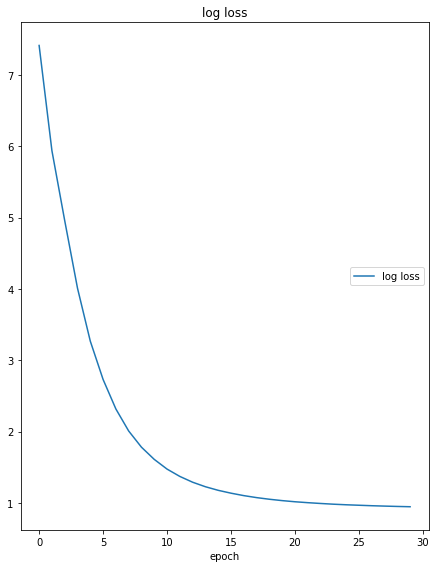

log loss
	log loss         	 (min:    0.945, max:    7.415, cur:    0.945)


In [13]:
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

input_size = 128
n_hidden = 128                         
n_layers = 1
embedding_dim = input_size
n_unique_words = len(words_dataset.unique_words)
batch_size = 350
sequence_length = 4

lr = 5e-3
momentum = 0.5
n_epochs = 30

lstm_gen = LSTM_GEN(input_size, embedding_dim, n_hidden, n_layers, n_unique_words).to(device)
print(f'The model has {count_trainable_parameters(lstm_gen):,} trainable parameters')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_gen.parameters(), lr=lr)

words_dataset = WordsTensorDataset(data, sequence_length=sequence_length)
words_dataloader = DataLoader(words_dataset, batch_size=batch_size, shuffle=False)  

# Keep track of losses for plotting
liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss = train_lstm_gen(lstm_gen, optimizer, criterion, words_dataloader)

    print(epoch,train_loss)

    logs['' + 'log loss'] = train_loss.item()
    liveloss.update(logs)
    liveloss.draw()

In [14]:
print(predict_lstm_gen(words_dataset, lstm_gen, text='Knock knock. Whos there?', next_words=100))

Knock knock. Whos there? Well, you better get glasses, and stop doing drugs A stamp collector walks into a bar... And asks the nearest person "Hey, is the bar tender here?" I tired playing soccer But I couldn't get a medal... What do you call a deep-sea diving dog? Scuba - Doo! Where did the fish go when it needed an operation? To the sturgeon My English teacher got really angry about the format of my essay. It wasn't justified. Starcraft: Why did the knob say to the rock? I wish I was a little boulder! What goes up and down but does not
